# Classification of Genomic Structural Variants
## Gaussian Mixture Model Method Development

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.cluster import KMeans as km
from sklearn.mixture import GaussianMixture as GMM
import sklearn.metrics as metrics

### Synthetic Data

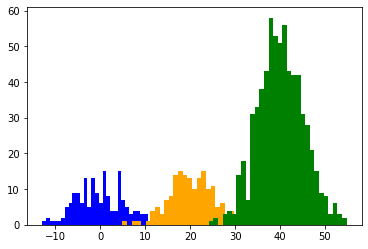

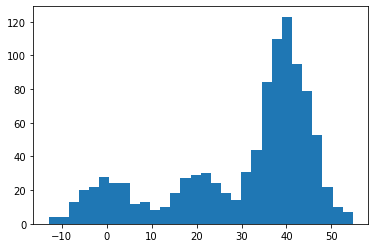

In [13]:
# Generating data that contains 3 normal distributions
# - the first two modes comprise 1/6 of the data
# - the third mode comprises 2/3 of the data
# - the first mode has its mean centered around 0, mu_1
# - the second mode has its mean centered around some mu_2
# - the third mode has its mean coupled with the second, being 2 * mu_2
# - all the modes have equal standard deviation

data = []
N = 1000
mu = 20
sigma = 5
bins = 30

N_0 = int(N/6) # 1/6
mode_1 = np.random.normal(0, sigma, N_0) # mean at zero, std at random value

N_1 = int(N/6) # 1/6 
mode_2 = np.random.normal(mu, sigma, N_1) # mean at random value, std at same value

N_2 = N - (N_0+N_1) # 2/3
mode_3 = np.random.normal(2*mu, sigma, N_2) # mean at twice the second mode's mean, std at same value

data.extend(mode_1)
data.extend(mode_2)
data.extend(mode_3)

plt.hist(mode_1, bins = bins, color = 'blue')
plt.hist(mode_2, bins = bins, color = 'orange')
plt.hist(mode_3, bins = bins, color = 'green')
plt.show()

plt.hist(data, bins = bins)
plt.show()

### Gaussian Mixture Model

In [14]:
# Plotting the data according to the mean, standard deviation, weight, and if the histogram should be plotted
# - the function checks a boolean to see if the data should be plotted on a histogram for comparison purposes
# - the output plot will be a lineplot, with the first mode being blue (the lowest mean being zero)
# - the third mode will be green, have the highest mean as the mean should be non-negative and twice the mean of the second mode
# - the second mode will be orange, and its mean will be between the other two
# - the x-values, being the curve, will be an evenly-spaced interval of 100 numbers
# - the lower-bound of the x-value interval will be 3 standard deviations below the mean
# - the upper-bound of the x-value interval will be 3 standard deviations above the mean
# - from the curve, we get our resulting lineplot by inputting the curve values into the PDF of the Normal Distribution
# - these values from the Normal PDF are then normalized according to the weight input from the GMM 

def plot_distributions(data, mu, sigma, pi, hist):
    if hist == True: # histogram underlay
        plt.hist(data, bins=30, density = True, alpha = 0.5)
    color = ''
    for k in range(3):
        if mu[k] == min(mu): # first mode
            color = 'blue'
        elif mu[k] == max(mu): # third mode
            color = 'green'
        else: # second mode 
            color = 'orange'
        curve = np.linspace(mu[k] - 3*sigma[k], mu[k] + 3*sigma[k], 100) # 100 numbers surrounding mean, bounded by 3 * std
        plt.plot(curve, pi[k]*stats.norm.pdf(curve, mu[k], sigma[k]), color) # Normal PDF values scaled by weight

In [15]:
# Distance function taking absolute distance

def dist(a,b):
    return np.abs(b - a)

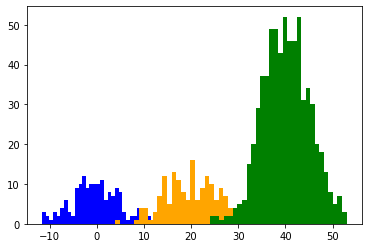

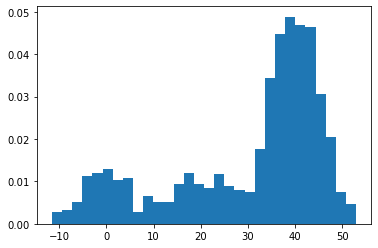

weights [0.15327514 0.18590264 0.66082222]
means [-0.67898747 19.84455025 40.18827052]
stds [4.69672283 4.87216618 6.81462345]


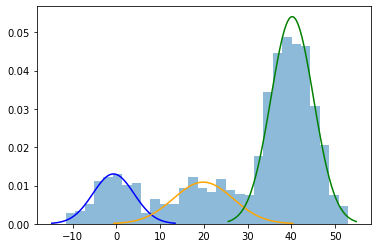

In [16]:
# Taking in the synthetic data from earlier

data = []
bins = 30
N = 1000
N_0 = int(N/6)
N_1 = int(N/6)
N_2 = N - (N_0+N_1)

mu = 20
sigma = 5
mode_1 = np.random.normal(0, sigma, N_0)
mode_2 = np.random.normal(mu, sigma, N_1)
mode_3 = np.random.normal(2*mu, sigma, N_2)

data.extend(mode_1)
data.extend(mode_2)
data.extend(mode_3)

plt.hist(mode_1, bins = bins, color = 'blue')
plt.hist(mode_2, bins = bins, color = 'orange')
plt.hist(mode_3, bins = bins, color = 'green')
plt.show()

plt.hist(data, bins = bins, density = True)
plt.show()

# TODO: potentially find better inital guess method?
# First Step: k-means clustering

k = 3 # number of modes
f = np.ravel(data).astype(float) # prepping data for built-in k-means
f = f.reshape(-1,1) 
kmeans = km(n_init = 3, n_clusters=3)
kmeans.fit(f) 
centers = np.sort(np.ravel(kmeans.cluster_centers_)) # storing centroids
mu = centers # initial mu values
sigma = [np.std(data), np.std(data), np.std(data)] # initial std values
pi = np.ones(3) * (1.0/3) # mixing coefficients
r = np.zeros([3,N]) # responsibilities
ll_list = [] # log-likelihood list
iteration = 0 
distance = 1

while distance > 1e-6: # convergence criterion

    # Expectation Step
    for k in range(3):
        # set responsibility of each point to PDF using estimated parameters, scaled by the mixing coefficient
        r[k,:] = pi[k] * stats.norm.pdf(x=data, loc=mu[k], scale=sigma[k])
    r = r / np.sum(r, axis=0) # normalize the data 
        

    # Maximization Step
    N_k = np.sum(r, axis=1) # total responsibility for each mode
    for k in range(3):
        mu[k] = np.sum(r[k,:] * data) / N_k[k] # update mean
        numerator = r[k] * (data - mu[k])**2
        sigma[k] = np.sqrt(np.sum(numerator) / N_k[k]) # update std
    pi = N_k/N # update mixing coefficient
        
    # Likelihood Calculation
    likelihood = 0.0
    for k in range(3):
        likelihood += pi[k] * stats.norm.pdf(x=data, loc=mu[k], scale=sigma[k])
    ll_list.append(np.sum(np.log(likelihood)))
    
    iteration += 1
    if iteration > 1: # as soon as there are 2 points to compare
        distance = dist(ll_list[-1],ll_list[-2]) # take distance

print('weights', np.sort(np.ravel(pi)))
print('means', np.sort(np.ravel(mu)))
print('stds', np.sort(np.ravel(sigma)))
plot_distributions(data, mu, sigma, pi, True)

In [17]:
# Based on parameters, generate a set of data, depending on:
# - number of observations
# - proportion of observations in each mode
# - vector of means
# - vector of standard deviations
# - generate a three-mode set of data, where each mode is a normal distribution

def dataGenerator(N, p_N, mu, sigma):
    
    data = []
    N_0 = int(p_N[0] * N)
    N_1 = int(p_N[1] * N)
    N_2 = int(p_N[2] * N)
    bins = 30
    
    mode_1 = np.random.normal(mu[0], sigma[0], N_0)
    mode_2 = np.random.normal(mu[1], sigma[1], N_1)
    mode_3 = np.random.normal(mu[2], sigma[2], N_2)

    data.extend(mode_1)
    data.extend(mode_2)
    data.extend(mode_3)
    
    return data

In [18]:
# Defining a function based on previous GMM algorithm, taking in:
# - count data
# - whether or not to plot
# - whether or not the plot should be a histogram

def gaussianPlot(data, plot, hist):
    # First Step: k-means clustering

    k = 3 # number of modes
    N = len(data) # number of observations
    f = np.ravel(data).astype(float) # prepping data for built-in k-means
    f = f.reshape(-1,1) 
    kmeans = km(n_init=3, n_clusters=3)
    kmeans.fit(f) 
    centers = np.sort(np.ravel(kmeans.cluster_centers_)) # storing centroids
    mu = centers # initial mu values
    sigma = [np.std(data), np.std(data), np.std(data)] # initial std values
    pi = np.ones(3) * (1.0/3) # mixing coefficients
    r = np.zeros([3,N]) # responsibilities
    ll_list = [] # log-likelihood list
    iteration = 0 
    distance = 1

    while distance > 1e-6: # convergence criterion

        # Expectation Step
        for k in range(3):
            # set responsibility of each point to PDF using estimated parameters, scaled by the mixing coefficient
            r[k,:] = pi[k] * stats.norm.pdf(x=data, loc=mu[k], scale=sigma[k])
        r = r / np.sum(r, axis=0) # normalize the data 


        # Maximization Step
        N_k = np.sum(r, axis=1) # total responsibility for each mode
        for k in range(3):
            mu[k] = np.sum(r[k,:] * data) / N_k[k] # update mean
            numerator = r[k] * (data - mu[k])**2
            sigma[k] = np.sqrt(np.sum(numerator) / N_k[k]) # update std
            if sigma[k] < 0.1: # lower bound for standard deviation
                sigma[k] = 0.1 
        pi = N_k/N # update mixing coefficient

        # Likelihood Calculation
        likelihood = 0.0
        for k in range(3):
            likelihood += pi[k] * stats.norm.pdf(x=data, loc=mu[k], scale=sigma[k])
        ll_list.append(np.sum(np.log(likelihood)))

        iteration += 1
        if iteration > 1: # as soon as there are 2 points to compare
            distance = dist(ll_list[-1],ll_list[-2]) # take distance
    if plot == True: # plot the results 
        plot_distributions(data, mu, sigma, pi, hist)
    return mu, sigma, pi

(array([-0.48432877, 20.74244643, 40.08170601]),
 [4.7687332344156, 5.798203604574358, 4.542727361696917],
 array([0.15717529, 0.17419175, 0.66863296]))

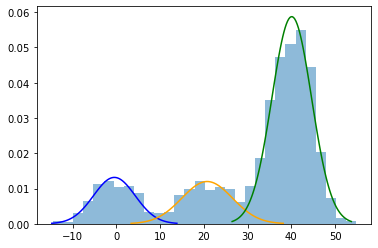

In [19]:
# Generate a data set
# - 1000 observations
# - first mode is 1/6 of the data
# - second mode is 1/6 of the data
# - third mode is 2/3 of the data
# - the means are at 0, 20, 40
# - the standard deviations are each 5
# - plot the resulting GMM, and the underlying histogram for the data points

X = dataGenerator(N = 1000, p_N = [0.16, 0.16, .68], mu = [0, 20, 40], sigma = [5, 5, 5])
gaussianPlot(X, True, True)

### Goodness of Clustering

In [9]:
# Implementing a goodness-of-clustering test, based on silhouette coefficient
# - set the range of clusters between 2 and 3
# - run the test over 20 iterations for each number of clusters (2 and 3)
# - get the silhouette score of the GMM
# - get the best 5 runs out of 20 (higher score is better), take the mean
# - return the number of clusters of the highest score (between 2 and 3 clusters)

def bestScore(arr:list, X:int)->list:
    dx=np.argsort(arr)[:X]
    return arr[dx]
def bestFit(data, k_0 = 2, k_1 = 3):
    f = np.ravel(data).astype(float)
    f=f.reshape(-1,1)
    n_clusters=np.arange(k_0, k_1+1)
    sils=[]
    iterations=20
    for n in n_clusters:
        tmp_sil=[]
        for _ in range(iterations):
            gmm=GMM(n, n_init=10).fit(f) # f - data
            labels=gmm.predict(f)
            sil=metrics.silhouette_score(f, labels, metric='euclidean') # labels - results of GMM
            tmp_sil.append(sil)
        val=np.mean(bestScore(np.array(tmp_sil), int(iterations/5)))
        sils.append(val)
    print(sils)
    if sils[0] > sils[1]:
        return k_0
    else:
        return k_1

In [10]:
# Generate a data set, where the weights of each mode varies by an incremental amount
# - 3000 observations
# - means of 0, 20, 40
# - standard deviation of 5
# - proportion range between 0 to ~1/3

N = 3000
mu = [0, 20, 40]
sigma = [5, 5, 5]
p_range = np.linspace(0.0, 0.33, 10)

ps = []
n_clusters = []

# loop through 10 iterations of varying proportions
# first mode has varying propotion
# other two modes have remaining, equal proportions
# store proportion of weight in the first cluster and the better number of clusters

for p in p_range:
    v_N = []
    v_N.append(p)
    v_N.append((1-p)/2)
    v_N.append((1-p)/2)
    X = dataGenerator(N, v_N, mu, sigma)
    ps.append(p)
    n_clusters.append(bestFit(X))

[0.705313760594852, 0.5771195773739191]
[0.6770654763750963, 0.6649563336627271]
[0.6263904406712938, 0.6703349104522257]
[0.6180290629349668, 0.677167214494073]
[0.5917357199627529, 0.6757844394416188]
[0.5897878802712063, 0.6780318488132108]
[0.5721520321080777, 0.6807563040340441]
[0.5819376336841579, 0.679667711995883]
[0.5897596967284461, 0.6857764112897097]
[0.6001237056439451, 0.6907318380014628]


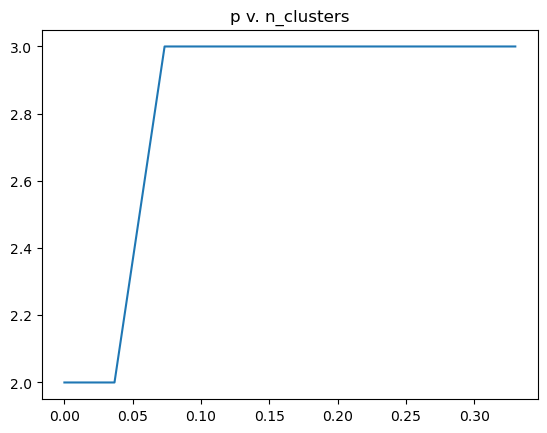

In [11]:
# plot the first mode proportion (x-axis) against number of clusters (y-axis)

plt.title('p v. n_clusters')
plt.plot(ps, n_clusters)

In [12]:
# list the increments of first mode proportion and the better fit for number of clusters

print(list(zip(ps, n_clusters)))

[(0.0, 2), (0.03666666666666667, 2), (0.07333333333333333, 3), (0.11, 3), (0.14666666666666667, 3), (0.18333333333333335, 3), (0.22, 3), (0.25666666666666665, 3), (0.29333333333333333, 3), (0.33, 3)]


In [13]:
# Create a test where the first mode varies by a fixed amount, but the data generated may also vary
# - takes in number of observations
# - takes in vector of means
# - takes in vector of standard deviations
# - takes in number of increments of first mode proportion
# - plot and list out results

def pPlot(N, mu, sigma, n_ps):
    p_range = np.linspace(0.0, 0.33, n_ps)

    ps = []
    n_clusters = []

    for p in p_range:
        v_N = []
        v_N.append(p)
        v_N.append((1-p)/2)
        v_N.append((1-p)/2)
        X = dataGenerator(N, v_N, mu, sigma)
        ps.append(p)
        n_clusters.append(bestFit(X))
    plt.title(('p v. n_clusters for N =' + str(N)))
    plt.plot(ps, n_clusters)
    plt.show()
    print(list(zip(ps, n_clusters)))

[0.8855504905870817, 0.7072953753630434]
[0.8446519974087805, 0.8801889447519897]
[0.8060199261982834, 0.8788777227823124]
[0.7722165951367277, 0.8787591156076833]
[0.7504614112921384, 0.8796455006117245]
[0.7322358938806424, 0.8826543689623861]
[0.7189224777045994, 0.882909952854798]
[0.7039637893393422, 0.881613825216493]
[0.6959570950359757, 0.8797280025035351]
[0.6930866729664786, 0.8821588101147397]


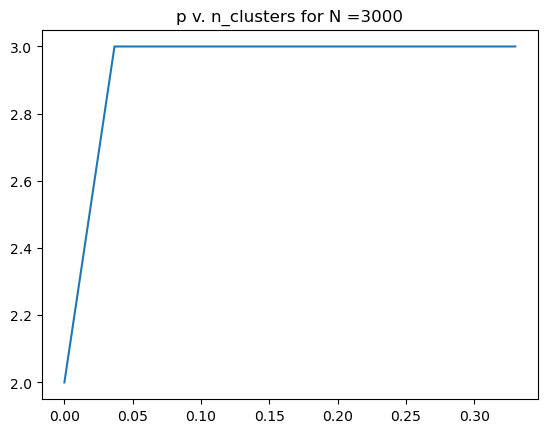

[(0.0, 2), (0.03666666666666667, 3), (0.07333333333333333, 3), (0.11, 3), (0.14666666666666667, 3), (0.18333333333333335, 3), (0.22, 3), (0.25666666666666665, 3), (0.29333333333333333, 3), (0.33, 3)]
[0.5493695811715863, 0.5323531984813311]
[0.5481484921692655, 0.5379677856094394]
[0.5537690816838742, 0.5315947244906882]
[0.554924304164009, 0.5239330486333186]
[0.5562109295819038, 0.5219429664804743]
[0.5546382450527544, 0.5269894731343816]
[0.5549463842345462, 0.5291519098334161]
[0.5527748164343681, 0.5385478706909723]
[0.5559971033078673, 0.5192326741857546]
[0.5564969377136304, 0.5213091709103463]


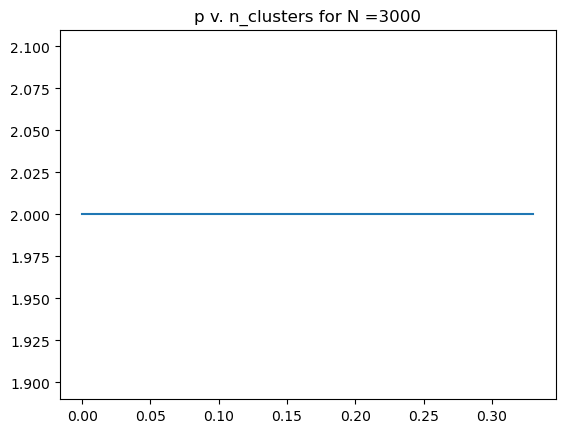

[(0.0, 2), (0.03666666666666667, 2), (0.07333333333333333, 2), (0.11, 2), (0.14666666666666667, 2), (0.18333333333333335, 2), (0.22, 2), (0.25666666666666665, 2), (0.29333333333333333, 2), (0.33, 2)]
[0.6077021991749474, 0.5401268819777117]
[0.5991321443725179, 0.5454258254198127]
[0.5827753439815, 0.5611375249994633]
[0.5868695554121145, 0.5614439255469641]
[0.5760673443029948, 0.566660031009078]
[0.5867176012253158, 0.5655690021957367]
[0.5865185426276214, 0.5768581625740199]
[0.5979052239495282, 0.5686679994933704]
[0.6001369156632855, 0.5715245209025134]
[0.6037794089042073, 0.5794483458091397]


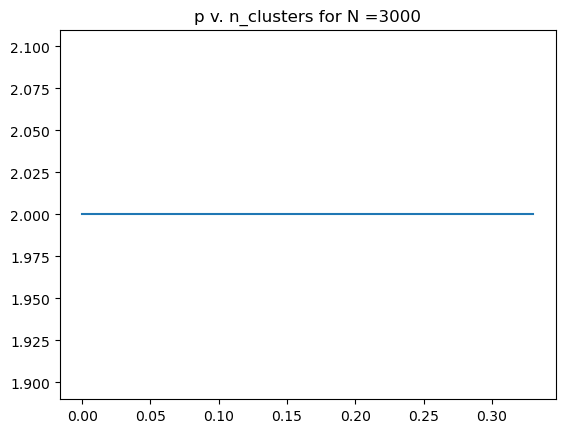

[(0.0, 2), (0.03666666666666667, 2), (0.07333333333333333, 2), (0.11, 2), (0.14666666666666667, 2), (0.18333333333333335, 2), (0.22, 2), (0.25666666666666665, 2), (0.29333333333333333, 2), (0.33, 2)]


In [14]:
# Generate a data set and determine when switch for best fit of clustering occurs (for # of clusters)
# - three iterations of varying means, ten increments for first mode proportion
# - list silhouette scores
# - plot first mode proportion against # of clusters in best fit
# - list out first mode proportion and # of clusters in best fit

N = 3000
mus = [[0, 20, 40],
       [5, 6, 7],
       [5, 10, 15]]
sigma = [2, 2, 2]
n_ps = 10

for mu in mus:
    pPlot(N, mu, sigma, n_ps)

### Hardy-Weinberg Equilibrium

0.20026768732104738
[1920.0000000000005, 960.0000000000002, 120.00000000000003]


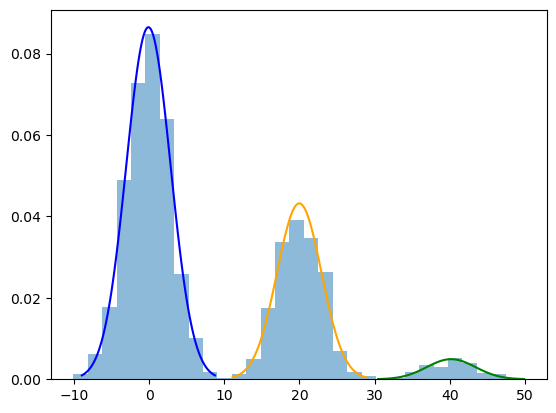

In [10]:
# HWE: p + q = 1, p^2 + 2pq + q^2
# p, the allele frequency of A
# q, the allele frequency of A'
# p^2, the frequency of homozygous dominant genotype
# 2pq, the frequency of heterozygous dominant genotype
# q^2, the frequency of homozygous recessive genotype

# Retrieve q, the proportion of alleles that are A'
# - to get q, one may take 1 - sqrt(p^2), based on HWE

def getQ(pi):
    return 1 - np.sqrt(pi[0])

# Generate a set of data, retrieve q from data based on results from GMM
# - set q = 0.2
# - have first mode be frequency of dominant homozygote 
# - have second mode be frequency of heterozygote
# - have third mode be frequency of recessive homozygote
# - set mean vector to 0, 20, 40
# - set std vector to 3
# - return q, # of observations in each mode

q = 0.2
v_N = [((1-q)**2),
       (2*q*(1-q)),
       (q**2)]
mu_1 = 0
mu_2 = 20
mu_3 = 2 * mu_2
N = 3000
mu = [mu_1, mu_2, mu_3]
X = dataGenerator(N, v_N, mu = mu, sigma = [3, 3, 3])
mu, sigma, pi = gaussianPlot(X, True, True)
print(getQ(pi))
print([n * 3000 for n in v_N])

In [11]:
# Get 95% confidence interval of q, print and plot results
# - sample the data with replacement
# - run EM on subset
# - store q values, determined from weight parameter
# - store confidence interval based on list of q values

conf = 0.95
q_vals = []

for _ in range(100):
    x = [np.random.choice(X) for _ in range(3000)]
    mu, sigma, pi = gaussianPlot(x, False, True) 
    q_vals.append(getQ(pi))     
    
ci = np.percentile(q_vals,[100*(1-conf)/2,100*(1-(1-conf)/2)]) 

0.20083546718791198
0.1909471020914353 0.2107833667939231


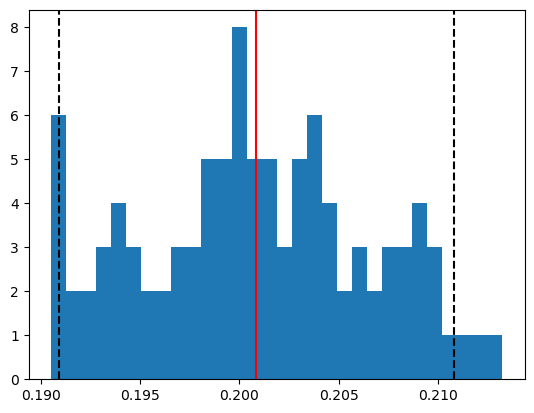

In [12]:
# plot the q-values, the confidence interval, and the mean

plt.hist(q_vals, bins = 30)
plt.axvline(np.mean(q_vals), color='red')
plt.axvline(ci[0], color = 'k', linestyle = '--')
plt.axvline(ci[1], color = 'k', linestyle = '--')
print(np.mean(q_vals))
print(ci[0],ci[1])

In [13]:
# Create a function that bootstraps the value of q
# - takes in the number of simulations to run
# - takes in the confidence level (usually 95%)
# - takes in boolean to see if plotting is necessary
# - samples data, with replacement, over the entire dataset
# - determines relevant parameters, determines q from weight parameter (pi)
# - takes confidence interval of stored q values
# - plots the result

def bootstrapQ(sims, conf, plot):
    conf = conf
    q_vals = []

    for _ in range(sims):
        x = [np.random.choice(X) for _ in range(len(X))] # N-size bootstrap sampling
        mu, sigma, pi = gaussianPlot(x, False, True) 
        q_vals.append(getQ(pi))     

    ci = np.percentile(q_vals,[100*(1-conf)/2,100*(1-(1-conf)/2)])
    if plot == True:
        plt.hist(q_vals, bins = 30)
        plt.axvline(np.mean(q_vals), color='red')
        plt.axvline(ci[0], color = 'k', linestyle = '--')
        plt.axvline(ci[1], color = 'k', linestyle = '--')
    return np.mean(q_vals), ci

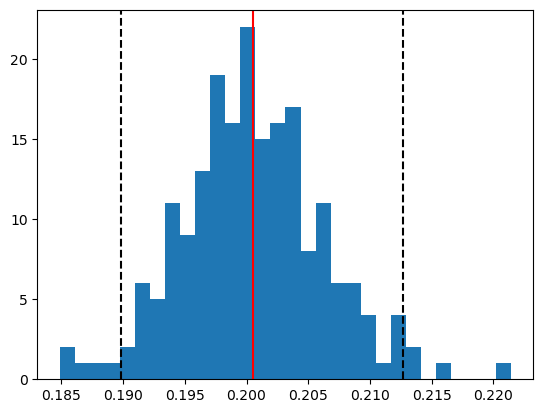

In [14]:
# plot mean q value and associated confidence interval

q_hat, q_ci = bootstrapQ(200, .95, True) 

In [15]:
# Return mu value from second mode

def getMu(mu):
    return mu[1]

In [16]:
# Create a function that bootstraps the value of mu_2
# - takes in the number of simulations to run
# - takes in the confidence level (usually 95%)
# - takes in boolean to see if plotting is necessary
# - samples data, with replacement, over the entire dataset
# - determines relevant parameters, determines mu_2 from mean parameter (mu)
# - takes confidence interval of stored mu values
# - plots the result

def bootstrapMu(sims, conf, plot):
    conf = conf
    mu_vals = []

    for _ in range(sims):
        x = [np.random.choice(X) for _ in range(len(X))]
        mu, sigma, pi = gaussianPlot(x, False, True) 
        mu_vals.append(getMu(mu))     

    ci = np.percentile(mu_vals,[100*(1-conf)/2,100*(1-(1-conf)/2)])
    if plot == True:
        plt.hist(mu_vals, bins = 30)
        plt.axvline(np.mean(mu_vals), color='red')
        plt.axvline(ci[0], color = 'k', linestyle = '--')
        plt.axvline(ci[1], color = 'k', linestyle = '--')
    return np.mean(mu_vals), ci, mu_vals

[20.00041720652795, 20.11541802629817, 19.990390883643066, 19.907785729197244, 20.09953808625066, 20.087425908854, 19.9898292776514, 19.996694553266945, 19.78168804989751, 19.80452726200583, 19.85893105802691, 20.08373800256865, 20.091448659604566, 20.122884275381185, 19.93820469074336, 19.938963815758743, 20.109387446139507, 19.93765003519436, 19.87748625882657, 20.031993961418685, 19.980393034638723, 20.04552545771549, 19.90640409026826, 19.998266087539886, 19.87712470606732, 19.96551566070511, 20.104158814150445, 19.90300782611542, 19.940566764231214, 20.111376088978858, 19.952823571516696, 19.76841686996619, 20.056007259990682, 19.958624072643044, 19.959608447293782, 19.91111178778295, 19.817696690348264, 20.031676273868342, 20.006701210598095, 20.061914233766526, 20.02766692331172, 20.045841689853653, 19.98689224636112, 20.064750950853522, 19.958478248416238, 20.041520963048796, 20.21273470291126, 19.967549680061058, 19.885250061854332, 19.915870810821172, 20.023995497788945, 19.9

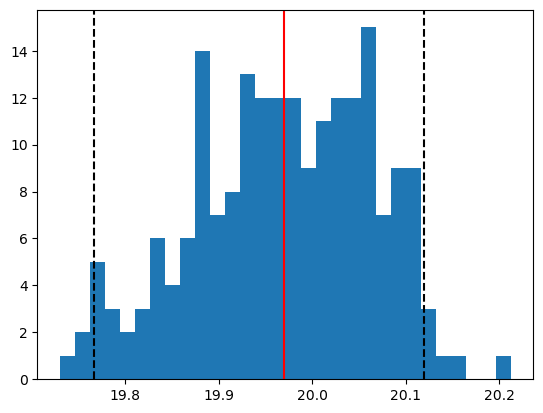

In [17]:
# plot average mu_2 value and associated confidence interval

mu_mean, mu_ci, mu_vals = bootstrapMu(200, .95, True)

### P-Value Calculation

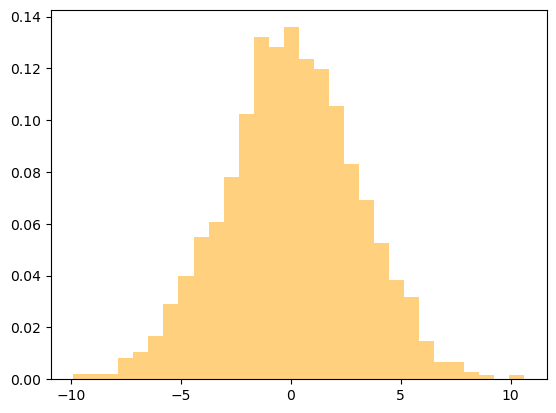

In [19]:
# Generate Null Distribution
# - the null distribution will be based on q = 0
# - the first mode will be centered around mu_1 = 0
# - the second mode will be some mu_2
# - the third mode will be twice the value of mu_2
# - the standard deviation will be a consistent value
# - plot distribution

q = 0
v_N = [((1-q)**2),
       (2*q*(1-q)),
       (q**2)]
N = 3000
mu_1 = 0
mu_2 = 20
mu_3 = 2 * mu_2
mu = [mu_1, mu_2, mu_3]
X = dataGenerator(N, v_N, mu = mu, sigma = [3, 3, 3])
plt.hist(X, bins = 30, density = True, color = 'orange', alpha = 0.5)
plt.show()

In [24]:
# Create a function that will generate the null distribution
# - takes in number of observations
# - takes in mu_2 value
# - takes in vector of standard deviations
# - generates a normal distribution based on the premise of q = 0

def nullDist(N, mu_2, sigma):
    q = 0
    v_N = [((1-q)**2),
           (2*q*(1-q)),
           (q**2)]
    mu_1 = 0
    mu_2 = mu_2
    mu_3 = 2 * mu_2
    X = dataGenerator(N, v_N, mu = [mu_1, mu_2, mu_3], sigma = [sigma, sigma, sigma])
    return X

(array([0.00101228, 0.00151841, 0.00303683, 0.00607366, 0.01214732,
        0.02024553, 0.03542968, 0.04150333, 0.06630411, 0.07996984,
        0.08250053, 0.10426447, 0.13007752, 0.13665732, 0.12653456,
        0.11489338, 0.11236268, 0.10932586, 0.0966724 , 0.07642687,
        0.0556752 , 0.03644195, 0.02581305, 0.01619642, 0.00961663,
        0.00809821, 0.00455524, 0.00303683, 0.00050614, 0.00151841]),
 array([-9.47951127, -8.82092964, -8.16234801, -7.50376638, -6.84518476,
        -6.18660313, -5.5280215 , -4.86943987, -4.21085824, -3.55227662,
        -2.89369499, -2.23511336, -1.57653173, -0.9179501 , -0.25936848,
         0.39921315,  1.05779478,  1.71637641,  2.37495804,  3.03353966,
         3.69212129,  4.35070292,  5.00928455,  5.66786618,  6.3264478 ,
         6.98502943,  7.64361106,  8.30219269,  8.96077432,  9.61935595,
        10.27793757]),
 <BarContainer object of 30 artists>)

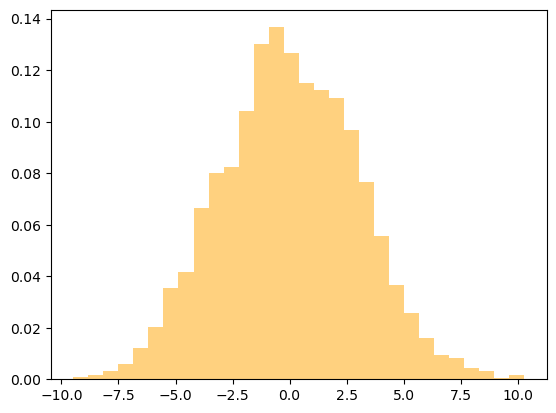

In [25]:
# plot the null distribution

plt.hist(nullDist(N, 20, 3), bins = 30, density = True, color = 'orange', alpha = 0.5)

(array([0.00041993, 0.        , 0.00041993, 0.        , 0.00083986,
        0.00083986, 0.00419928, 0.01007827, 0.01763698, 0.02729532,
        0.0373736 , 0.05375079, 0.0718077 , 0.09826317, 0.11925957,
        0.12345885, 0.13059763, 0.12639835, 0.10078274, 0.09952295,
        0.07894648, 0.05039137, 0.0449323 , 0.02771525, 0.01763698,
        0.0104982 , 0.00419928, 0.00125978, 0.00041993, 0.00083986]),
 array([-13.11157784, -12.31779111, -11.52400438, -10.73021765,
         -9.93643092,  -9.14264419,  -8.34885746,  -7.55507074,
         -6.76128401,  -5.96749728,  -5.17371055,  -4.37992382,
         -3.58613709,  -2.79235036,  -1.99856363,  -1.20477691,
         -0.41099018,   0.38279655,   1.17658328,   1.97037001,
          2.76415674,   3.55794347,   4.3517302 ,   5.14551692,
          5.93930365,   6.73309038,   7.52687711,   8.32066384,
          9.11445057,   9.9082373 ,  10.70202402]),
 <BarContainer object of 30 artists>)

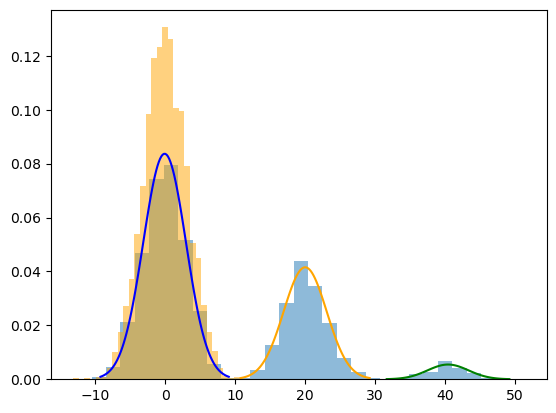

In [28]:
# Generate null distribution and plot it against a 3-mode model
# - set q = 0.2
# - set weight of each mode accordingly
# - 3000 observations
# - plot GMM, histogram, and null distribution

q = 0.2
v_N = [((1-q)**2),
       (2*q*(1-q)),
       (q**2)]
mu_1 = 0
mu_2 = 20
mu_3 = 2 * mu_2
N = 3000
mu = [mu_1, mu_2, mu_3]
X = dataGenerator(N, v_N, mu = mu, sigma = [3, 3, 3])
mu, sigma, pi = gaussianPlot(X, True, True)
plt.hist(nullDist(N, mu_2, sigma[0]), bins = 30, density = True, color = 'orange', alpha = 0.5)

(array([1710., 1475., 1233., 1053.,  926.,  885.,  796.,  646.,  703.,
         573.]),
 array([2.77934956e-04, 1.00243509e-01, 2.00209082e-01, 3.00174656e-01,
        4.00140230e-01, 5.00105804e-01, 6.00071377e-01, 7.00036951e-01,
        8.00002525e-01, 8.99968098e-01, 9.99933672e-01]),
 <BarContainer object of 10 artists>)

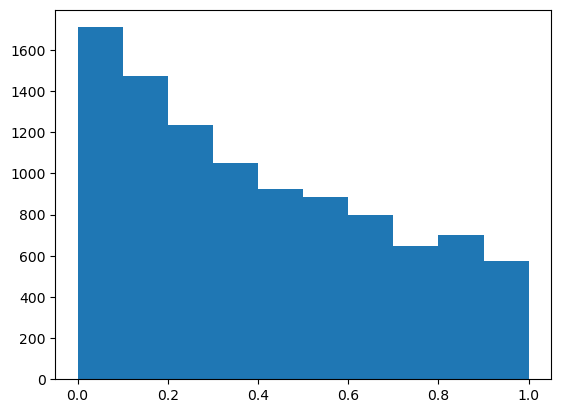

In [31]:
# Attempt to set up Kolmogorov-Smirnov Test
# - generate null distribution of 10000 data points
# - derive cumulative density function of entire data set
# - run 10,000 iterations
# - for each iteration, generate a null distribution of the same scope
# - get cdf of each null
# - compare cdf of each individual null to overall null using KS test statistic
# - plot p-values

ks_stat = []
p_val = []

null = nullDist(10000, 20, 3)
null_cdf = stats.norm.cdf(null)

for _ in range(10000):
    draw = nullDist(10000, 20, 3)
    draw_cdf = stats.norm.cdf(draw)
    p_val.append(stats.kstest(draw_cdf,null_cdf)[1])

plt.hist(p_val)

(array([8273.,  965.,  505.,    0.,  216.,    0.,    0.,    0.,    0.,
          41.]),
 array([4.23516917e-173, 1.38990574e-168, 2.77976912e-168, 4.16963251e-168,
        5.55949590e-168, 6.94935928e-168, 8.33922267e-168, 9.72908605e-168,
        1.11189494e-167, 1.25088128e-167, 1.38986762e-167]),
 <BarContainer object of 10 artists>)

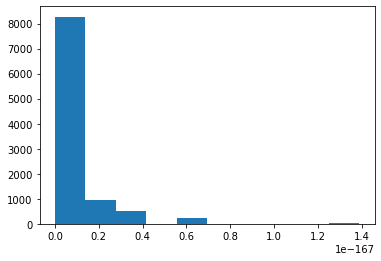

In [14]:
# Attempt to set up Kolmogorov-Smirnov Test
# - generate null distribution of 10000 data points
# - derive cumulative density function of entire data set
# - run 10,000 iterations
# - for each iteration, generate a 3-mode normal distribution of the same scope
# - get cdf of each 3-mode distribution
# - compare cdf of each 3-mode distribution to the cdf of each null distribution
# - plot p-values

ks_stat = []
p_val = []

null = nullDist(10000, 20, 3)
null_cdf = stats.norm.cdf(null)

for _ in range(10000):
    q = 0.2
    v_N = [((1-q)**2),
           (2*q*(1-q)),
           (q**2)]
    draw = dataGenerator(N, v_N, mu = mu, sigma = [3, 3, 3])
    draw_cdf = stats.norm.cdf(draw)

    p_val.append(stats.kstest(draw_cdf,null_cdf)[1])

plt.hist(p_val)

### Parameter Discovery

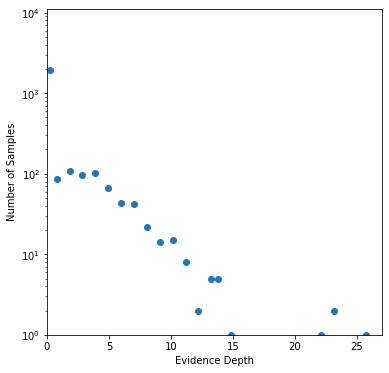

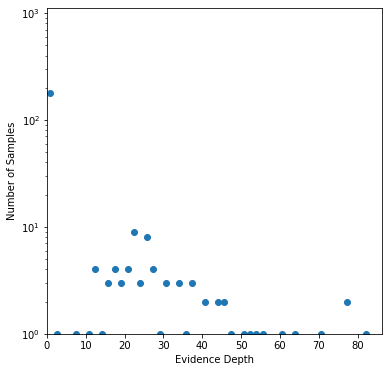

In [9]:
# Load in actual sample for structural variant data
# - read in data
# - take counts of each depth
# - arrange data as a histogram
# - plot data, as evidence depth against # of samples

fig, ax = plt.subplots(figsize = (6,6))
sv_1kg = pd.read_csv('../data/histogram_ex_1kg.csv', header = None)
samples_1kg = sv_1kg.values[0]
hist, bin_edges = np.histogram(samples_1kg, bins=50, density=False)
bin_center = (bin_edges[:-1] + bin_edges[1:])/2

plt.scatter(bin_center, hist)
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0)
plt.xlabel('Evidence Depth')
plt.ylabel('Number of Samples')
plt.show()

fig, ax = plt.subplots(figsize = (6,6))
sv_sgdp = pd.read_csv('../data/histogram_ex_sgdp.csv', header = None)
samples_sgdp = sv_sgdp.values[0]
hist, bin_edges = np.histogram(samples_sgdp, bins=50, density=False)
bin_center = (bin_edges[:-1] + bin_edges[1:])/2

plt.scatter(bin_center, hist)
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0)
plt.xlabel('Evidence Depth')
plt.ylabel('Number of Samples')
plt.show()

In [10]:
# Plot the GMM results against the sample SV data set
# - modify the plot to introduce sample data
# - expand range of model modes
# - normalize data to match probability and counts

# TODO: verify normalization method

def plot_distributions(data, mu, sigma, pi, hist):
    histX, bin_edgesX = np.histogram(samples_1kg, bins=50, density=False)
    if hist == True:
        plt.hist(data, bins=30, density = True, alpha = 0.5)
    color = ''
    for k in range(3):
        if mu[k] == min(mu):
            color = 'blue'
        elif mu[k] == max(mu):
            color = 'green'
        else:
            color = 'orange'
        curve = np.linspace(mu[k] - 5*sigma[k], mu[k] + 5*sigma[k], 100)
        plt.plot(curve, (np.max(histX)-np.min(histX))*pi[k]*stats.norm.pdf(curve, mu[k], sigma[k]), color)

In [8]:
# Determine which model has the proper standard deviation parameters
# - modify the first GMM to have all standard deviations be independent

def gaussianPlot3mode(data, plot, hist): 
    N = len(data)
    f = np.ravel(data).astype(float)
    f=f.reshape(-1,1)
    kmeans = km(n_init=3, n_clusters=3)
    kmeans.fit(f)
    centers = np.sort(np.ravel(kmeans.cluster_centers_))
    mu = centers
    sigma = [np.std(data), np.std(data), np.std(data)]
    pi = np.ones(3) * (1.0/3) # mixing coefficients
    r = np.zeros([3,N]) # responsibilities
    ll_list = list()
    iteration = 0
    distance = 1

    while distance > (1/(N*10)): # Convergence Criterion
        # Expectation Step
        for k in range(3):
            r[k,:] = pi[k] * stats.norm.pdf(x=data, loc=mu[k], scale=sigma[k])
        r = r / np.sum(r, axis=0) #[3,N] -> [N]


        # Maximization Step
        N_k = np.sum(r, axis=1)
        for k in range(3):
            mu[k] = (np.sum(r[k,:] * data)) / N_k[k]  # update mean, tolerance for mean
            numerator = r[k] * (data - mu[k])**2
            sigma[k] = np.sqrt(np.sum(numerator) / N_k[k]) # update std, tolerance for variance
            if sigma[k] < 0.01:
                sigma[k] = 0.01
        pi = N_k/N # update mixing coefficient

        # Likelihood Calculation
        likelihood = 0.0
        for k in range(3):
            likelihood += pi[k] * stats.norm.pdf(x=data, loc=mu[k], scale=sigma[k])
        ll_list.append(np.sum(np.log(likelihood)))

        iteration += 1
        if iteration > 1:
            distance = dist(ll_list[-1],ll_list[-2])
    if plot == True:
        plot_distributions(data, mu, sigma, pi, hist)
    return mu, sigma, pi, ll_list

In [9]:
# - modify the second GMM to restrict the third standard deviation be coupled with the third

def gaussianPlot2mode(data, plot, hist): 
    N = len(data)
    f = np.ravel(data).astype(float)
    f=f.reshape(-1,1)
    kmeans = km(n_init=3, n_clusters=3)
    kmeans.fit(f)
    centers = np.sort(np.ravel(kmeans.cluster_centers_))
    mu = centers
    sigma = [np.std(data), np.std(data), np.std(data)]
    pi = np.ones(3) * (1.0/3) # mixing coefficients
    r = np.zeros([3,N]) # responsibilities
    ll_list = list()
    iteration = 0
    distance = 1

    while distance > (1/(N*10)): # Convergence Criterion
        # Expectation Step
        for k in range(3):
            r[k,:] = pi[k] * stats.norm.pdf(x=data, loc=mu[k], scale=sigma[k])
        r = r / np.sum(r, axis=0) #[3,N] -> [N]


        # Maximization Step
        N_k = np.sum(r, axis=1)
        for k in range(3):
            mu[k] = (np.sum(r[k,:] * data)) / N_k[k]  # update mean, tolerance for mean
            numerator = r[k] * (data - mu[k])**2
        sigma[0] = np.sqrt(np.sum(r[0] * (data - mu[0])**2) / N_k[0])
        sigma[1] = np.sqrt(np.sum(r[1] * (data - mu[1])**2) / N_k[1])
        sigma[2] = sigma[1]
        for k in range(3):
            if sigma[k] < 1:
                sigma[k] = 1
        pi = N_k/N # update mixing coefficient

        # Likelihood Calculation
        likelihood = 0.0
        for k in range(3):
            likelihood += pi[k] * stats.norm.pdf(x=data, loc=mu[k], scale=sigma[k])
        ll_list.append(np.sum(np.log(likelihood)))

        iteration += 1
        if iteration > 1:
            distance = dist(ll_list[-1],ll_list[-2])
    if plot == True:
        plot_distributions(data, mu, sigma, pi, hist)
    return mu, sigma, pi, ll_list

In [28]:
# - modify the second GMM to restrict the third standard deviation be a multiple of the second

def gaussianPlotFactorMode(data, plot, hist): 
    N = len(data)
    f = np.ravel(data).astype(float)
    f=f.reshape(-1,1)
    kmeans = km(n_init=3, n_clusters=3)
    kmeans.fit(f)
    centers = np.sort(np.ravel(kmeans.cluster_centers_))
    mu = centers
    sigma = [np.std(data), np.std(data), np.std(data)]
    pi = np.ones(3) * (1.0/3) # mixing coefficients
    r = np.zeros([3,N]) # responsibilities
    ll_list = list()
    iteration = 0
    distance = 1

    while distance > (1/(N*10)): # Convergence Criterion
        # Expectation Step
        for k in range(3):
            r[k,:] = pi[k] * stats.norm.pdf(x=data, loc=mu[k], scale=sigma[k])
        r = r / np.sum(r, axis=0) #[3,N] -> [N]


        # Maximization Step
        N_k = np.sum(r, axis=1)
        for k in range(3):
            mu[k] = (np.sum(r[k,:] * data)) / N_k[k]  # update mean, tolerance for mean
            numerator = r[k] * (data - mu[k])**2
        sigma[0] = np.sqrt(np.sum(r[0] * (data - mu[0])**2) / N_k[0])
        sigma[1] = np.sqrt(np.sum(r[1] * (data - mu[1])**2) / N_k[1])
        sigma[2] = 2*sigma[1]
        for k in range(3):
            if sigma[k] < 1:
                sigma[k] = 1
        pi = N_k/N # update mixing coefficient

        # Likelihood Calculation
        likelihood = 0.0
        for k in range(3):
            likelihood += pi[k] * stats.norm.pdf(x=data, loc=mu[k], scale=sigma[k])
        ll_list.append(np.sum(np.log(likelihood)))

        iteration += 1
        if iteration > 1:
            distance = dist(ll_list[-1],ll_list[-2])
    if plot == True:
        plot_distributions(data, mu, sigma, pi, hist)
    return mu, sigma, pi, ll_list

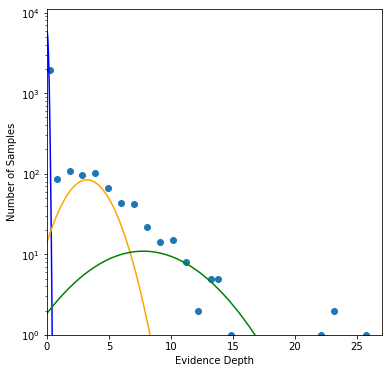

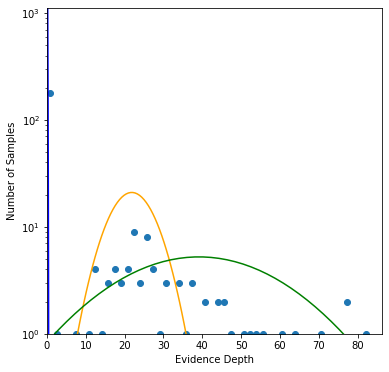

In [11]:
# Setting up test to see if plotting for sample structural variant data is proper

fig, ax = plt.subplots(figsize = (6,6))
sv_1kg = pd.read_csv('../data/histogram_ex_1kg.csv', header = None)
samples_1kg = sv_1kg.values[0]
hist, bin_edges = np.histogram(samples_1kg, bins=50, density=False)
bin_center = (bin_edges[:-1] + bin_edges[1:])/2

plt.scatter(bin_center, hist)
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0)
plt.xlabel('Evidence Depth')
plt.ylabel('Number of Samples')

mu, sigma, pi = gaussianPlot(samples_1kg, True, False) 
plt.show()

fig, ax = plt.subplots(figsize = (6,6))
sv_sgdp = pd.read_csv('../data/histogram_ex_sgdp.csv', header = None)
samples_sgdp = sv_sgdp.values[0]
hist, bin_edges = np.histogram(samples_sgdp, bins=50, density=False)
bin_center = (bin_edges[:-1] + bin_edges[1:])/2

plt.scatter(bin_center, hist)
ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_xlim(left=0)
plt.xlabel('Evidence Depth')
plt.ylabel('Number of Samples')

mu, sigma, pi = gaussianPlot(samples_sgdp, True, True) 
plt.show()

In [2]:
# Load in queries from STIX

file = '../data/1kg_stix_queries.txt'
stix_queries = pd.read_csv(file, sep = '\t')
stix_queries

,query_l,query_r,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,HG00103,HG00105,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
0,1:738222-738570,1:742020-742374,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:939918-939918,1:939968-939968,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:1294138-1294138,1:1294195-1294195,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1:1417868-1417868,1:1417928-1417928,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1:1240709-1240709,1:1240791-1240791,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12702,5:61721140-61721315,5:61722984-61723162,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12703,5:61911374-61911374,5:61911446-61911446,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12704,5:61424233-61424342,5:61470982-61471091,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12705,5:61900776-61900802,5:61904135-61904161,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Filter queries
# - drop queries with invalid values
# - drop frame data

stix_queries = stix_queries.dropna()
stix_queries = stix_queries.drop(columns=['query_l', 'query_r'])
stix_queries

,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,HG00103,HG00105,HG00106,HG00107,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12701,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12702,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12703,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12704,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Sample STIX queries and give summary statistics for sample

sample = list(stix_queries.sample(n=1).iloc[0])
pd.Series(sample).describe()

count    2535.000000
mean        0.012229
std         0.152098
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
dtype: float64

In [139]:
# Function to plot sample STIX query with GMM with all independent standard deviations

def sum3diff(sample):
    fig, ax = plt.subplots(figsize = (6,6))
    hist, bin_edges = np.histogram(sample, bins=50, density=False)
    bin_center = (bin_edges[:-1] + bin_edges[1:])/2

    plt.scatter(bin_center, hist)
    ax.set_yscale("log")
    ax.set_ylim(bottom=1)
    ax.set_xlim(left=0)
    plt.xlabel('Evidence Depth')
    plt.ylabel('Number of Samples')
    plt.title('Mode 2 =\= Mode 3')
    mu, sigma, pi, ll_list = gaussianPlot3mode(sample, True, False) 
    plt.show()
    return sigma # for pr(3_mode_sigma) analysis

In [39]:
# Function to plot sample STIX query GMM with coupled second and third standard deviations

def sum2diff(sample):
    fig, ax = plt.subplots(figsize = (6,6))
    hist, bin_edges = np.histogram(sample, bins=50, density=False)
    bin_center = (bin_edges[:-1] + bin_edges[1:])/2

    plt.scatter(bin_center, hist)
    ax.set_yscale("log")
    ax.set_ylim(bottom=1)
    ax.set_xlim(left=0)
    plt.xlabel('Evidence Depth')
    plt.ylabel('Number of Samples')
    plt.title('Mode 2 == Mode 3')
    mu, sigma, pi, ll_list = gaussianPlot2mode(sample, True, False) 
    plt.show()

In [40]:
# Function to plot sample STIX query GMM with third standard deviation being a multiple of the second standard deviation

def sumFactorDiff(sample):
    fig, ax = plt.subplots(figsize = (6,6))
    hist, bin_edges = np.histogram(sample, bins=50, density=False)
    bin_center = (bin_edges[:-1] + bin_edges[1:])/2

    plt.scatter(bin_center, hist)
    ax.set_yscale("log")
    ax.set_ylim(bottom=1)
    ax.set_xlim(left=0)
    plt.xlabel('Evidence Depth')
    plt.ylabel('Number of Samples')
    plt.title('2*(Mode 2) == Mode 3')
    mu, sigma, pi, ll_list = gaussianPlotFactorMode(sample, True, False) 
    plt.show()

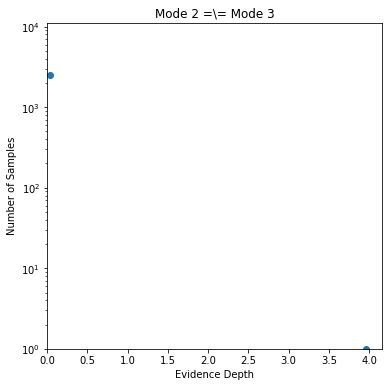

/var/folders/3v/8c4h0_nj36l6vkszy1szz5280000gn/T/ipykernel_73382/62279356.py:8: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(f)


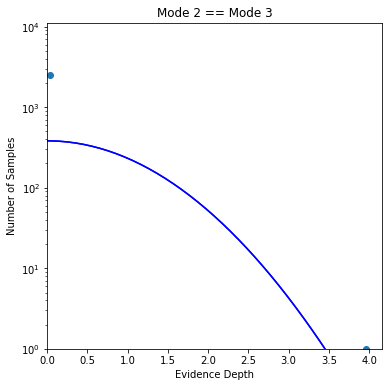

/var/folders/3v/8c4h0_nj36l6vkszy1szz5280000gn/T/ipykernel_73382/1003645481.py:8: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(f)


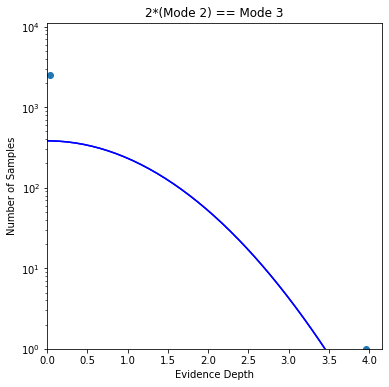

In [71]:
# Plot sample STIX query with each model

sample = list(stix_queries.sample(n=1).iloc[0])
sum3diff(sample)
sum2diff(sample)
sumFactorDiff(sample)

In [140]:
# Function to plot each of the 3 models, with varying levels of freedom for standard deviation
# - takes in the STIX query to be sampled
# - takes in the number of samples to take

def sample_STIX(query, num_samples):
    sample = query.sample(n=num_samples)
    for s_i in range(num_samples):
        sample_i = list(sample.iloc[s_i])
        sum3diff(sample_i)
        sum2diff(sample_i)
        sumFactorDiff(sample_i)

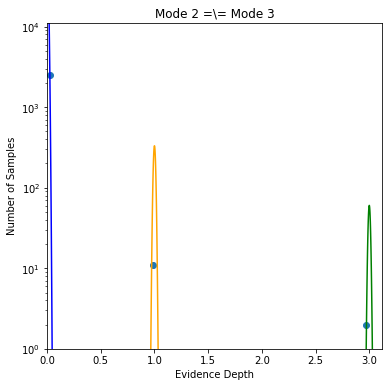

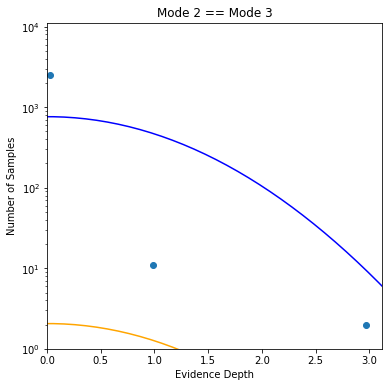

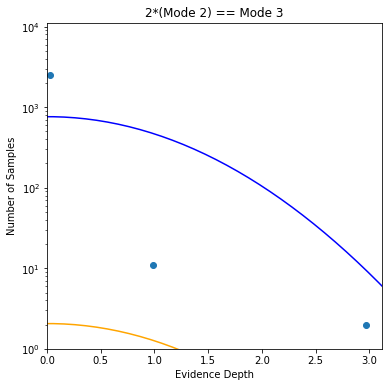

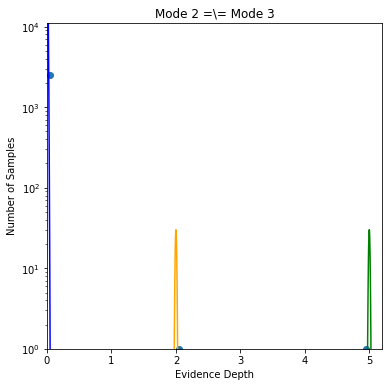

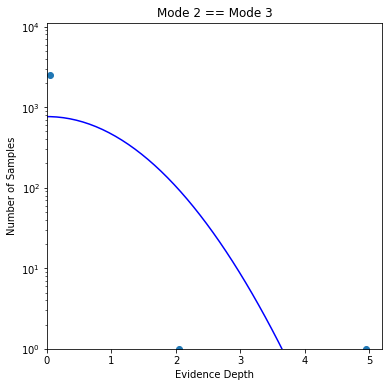

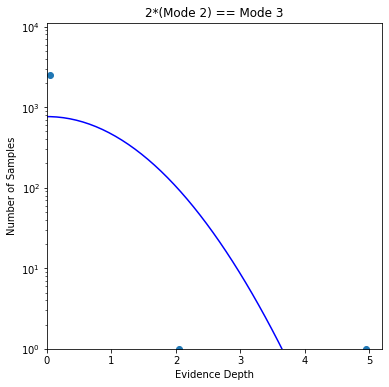

In [141]:
# Plot 3 models with varying standard deviation freedoms
# TODO: restrict query data set to those that are in HWE

sample_STIX(stix_queries, 2)

In [142]:
def sample_STIX_std(query, s):
    sample = query.sample(n=s)
    std2 = []
    std3 = [] 
    for s_i in range(s):
        sample_i = list(sample.iloc[s_i])
        stds = sum3diff(sample_i)
        std2.append(stds[0])
        std3.append(stds[1])
    return std2, std3

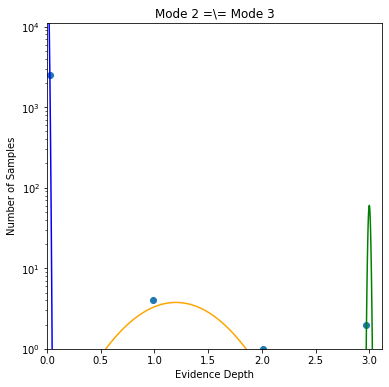

/var/folders/3v/8c4h0_nj36l6vkszy1szz5280000gn/T/ipykernel_73382/74581196.py:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(f)
/Users/behzod/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


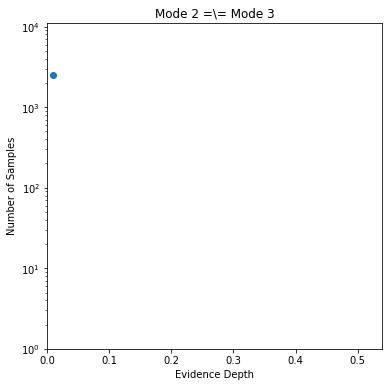

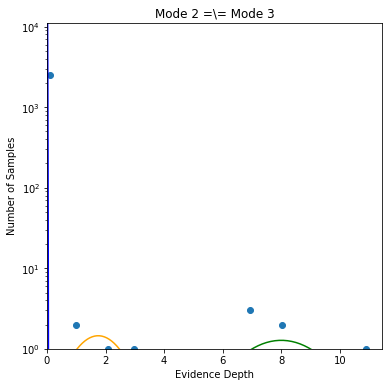

/var/folders/3v/8c4h0_nj36l6vkszy1szz5280000gn/T/ipykernel_73382/74581196.py:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(f)


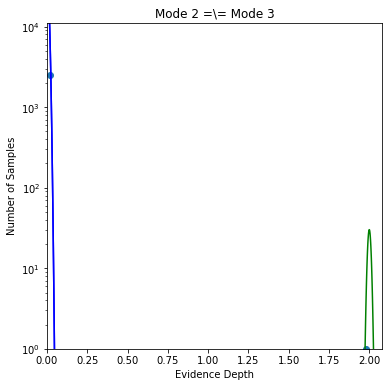

/var/folders/3v/8c4h0_nj36l6vkszy1szz5280000gn/T/ipykernel_73382/74581196.py:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(f)


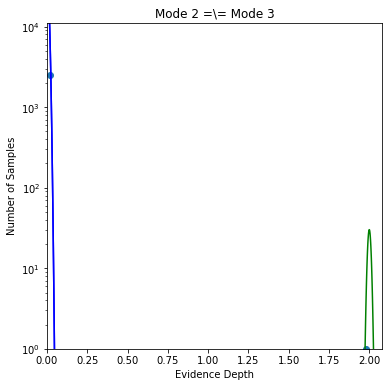

In [144]:
std2, std3 = sample_STIX_std(stix_queries, 5)

Text(0, 0.5, 'Frequency')

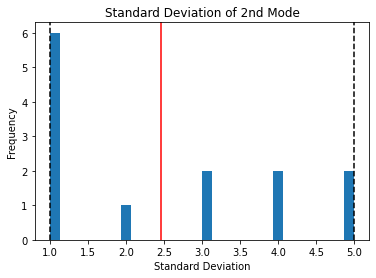

In [148]:
# Plot the standard deviation for the second mode
# - drop variances which are too small / defaulted to lower bound
# - take the 95% confidence interval
# - plot the results

# Test Value : std2 = [5, 2, 1, 1, 1, 1, 1, 1, 4, 5, 3, 3, 4]

std2 = [std for std in std2 if std != 0.01]
conf = 0.95
ci = np.percentile(std2,[100*(1-conf)/2,100*(1-(1-conf)/2)])
plt.hist(std2, bins = 30)
plt.axvline(np.mean(std2), color='red')
plt.axvline(ci[0], color = 'k', linestyle = '--')
plt.axvline(ci[1], color = 'k', linestyle = '--')
plt.title('Standard Deviation of 2nd Mode')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

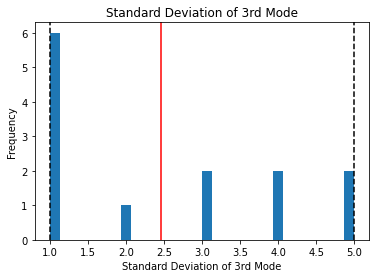

In [150]:
# Plot the standard deviation for the third mode
# - drop variances which are too small / defaulted to lower bound
# - take the 95% confidence interval
# - plot the results

# Test Value : std3 = [5, 2, 1, 1, 1, 1, 1, 1, 4, 5, 3, 3, 4]

conf = 0.95
ci = np.percentile(std3,[100*(1-conf)/2,100*(1-(1-conf)/2)])
plt.hist(std3, bins = 30)
plt.axvline(np.mean(std3), color='red')
plt.axvline(ci[0], color = 'k', linestyle = '--')
plt.axvline(ci[1], color = 'k', linestyle = '--')
plt.title('Standard Deviation of 3rd Mode')
plt.xlabel('Standard Deviation of 3rd Mode')
plt.ylabel('Frequency')